In [ ]:
import math
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import GPT2Tokenizer, DataCollatorForLanguageModeling
from datasets import load_dataset


In [ ]:
LiGO_bool = True
emb_size = 256
new_emb_size = 512
block_size = 128
multi_heads = 2
batch_size = 16
epochs = 3
learning_rate = 3e-4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

num_small_layers = 4
multi_heads = 2
num_large_layers = 8

In [347]:

# WikiText-103 dataset
# dataset = load_dataset('wikitext', 'wikitext-103-raw-v1')

# WikiText-2 dataset
dataset = load_dataset('wikitext', 'wikitext-2-raw-v1')

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')

# Add a padding token to the tokenizer
tokenizer.add_special_tokens({'pad_token': '[PAD]'})
vocab_size = len(tokenizer)

def tokenize_function(examples):
    return tokenizer(examples['text'], return_tensors='pt', truncation=True, padding='max_length', max_length=block_size)

tokenized_datasets = dataset.map(tokenize_function, batched=True, remove_columns=["text"])
data_collator = DataCollatorForLanguageModeling(tokenizer=tokenizer, mlm=False)

train_dataset = tokenized_datasets["train"]
val_dataset = tokenized_datasets["validation"]
train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size, collate_fn=data_collator)
val_dataloader = DataLoader(val_dataset, shuffle=False, batch_size=batch_size, collate_fn=data_collator)

### For Shakespear

In [348]:
# from datasets import load_dataset
# import os

# output_dir = 'processed_shakespeare'

# data_files = {
#     'train': os.path.join(output_dir, 'train.txt'),
#     'validation': os.path.join(output_dir, 'validation.txt'),
# }
# dataset = load_dataset('text', data_files=data_files)

In [349]:
print(dataset)

DatasetDict({
    test: Dataset({
        features: ['text'],
        num_rows: 4358
    })
    train: Dataset({
        features: ['text'],
        num_rows: 36718
    })
    validation: Dataset({
        features: ['text'],
        num_rows: 3760
    })
})


In [350]:
loss_fn = torch.nn.CrossEntropyLoss()

In [351]:
@torch.no_grad()
def validate(mdl, dataloader):
    mdl.eval()
    total_loss = 0
    num_batches = 0
    val_losses = []
    for batch in dataloader:
        inputs = batch["input_ids"].squeeze(1).to(device)
        outputs = mdl(inputs)
        loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
        total_loss += loss.item()
        num_batches += 1
        if num_batches % 100 == 0:
            val_losses.append(total_loss / num_batches)
    return total_loss / num_batches, val_losses

@torch.enable_grad()
def train(mdl, optim, epochs, train_dataloader, val_dataloader):
    mdl.to(device)
    train_losses = []
    val_losses_epoch = []
    for epoch in range(epochs):
        mdl.train()
        total_loss = 0
        num_batches = 0
        for batch in train_dataloader:
            inputs = batch["input_ids"].squeeze(1).to(device)
            optim.zero_grad()
            outputs = mdl(inputs)
            loss = loss_fn(outputs.view(-1, vocab_size), inputs.view(-1))
            loss.backward()
            optim.step()
            total_loss += loss.item()
            num_batches += 1
            if num_batches % 100 == 0:
                train_losses.append(total_loss / num_batches)

        avg_loss = total_loss / num_batches
        val_loss, val_losses = validate(mdl, val_dataloader)
        val_losses_epoch.extend(val_losses)
        print(f"Epoch {epoch+1}, Train Loss: {avg_loss:.4f}, Val Loss: {val_loss:.4f}")
    
    return train_losses, val_losses_epoch

In [352]:
class AttentionHead(torch.nn.Module):
    def __init__(self, big=False):
        super(AttentionHead, self).__init__()
        self.k = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.q = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.v = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size,block_size)))
    def forward(self, e):
        keys = self.k(e)
        queries = self.q(e)
        values = self.v(e)
        ret = keys @ queries.transpose(1, 2)*(1.0/math.sqrt(keys.size(-1)))
        ret = torch.masked_fill(ret, self.tril==0, -torch.inf)
        ret = torch.softmax(ret, 2)
        ret = ret @ values
        return ret

In [353]:
class MultiHead(torch.nn.Module):
    def __init__(self, big=False):
        super(MultiHead, self).__init__()
        self.head1 = AttentionHead(big)
        self.head2 = AttentionHead(big)
        self.mh_lin = torch.nn.Linear(multi_heads*(new_emb_size if big else emb_size), new_emb_size if big else emb_size, bias=False)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        x1 = self.head1(inp)
        x2 = self.head2(inp)
        return self.mh_lin(self.drop(torch.cat([x1,x2], dim=2))).relu()


In [354]:
class Block(torch.nn.Module):
    def __init__(self, big=False):
        super(Block, self).__init__()
        self.multihead = MultiHead(big)
        self.l_norm_1 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.l_norm_2 = torch.nn.LayerNorm(new_emb_size if big else emb_size)
        self.ffn = torch.nn.Linear(new_emb_size if big else emb_size, new_emb_size if big else emb_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        m = self.l_norm_1(inp + self.multihead(inp))
        m = self.l_norm_2(m + self.ffn(self.drop(m)).relu())
        return m

In [355]:
class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

In [356]:
class Model(torch.nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, emb_size)
        self.pe = PositionalEncoding(emb_size)
        self.block1 = Block()
        self.block2 = Block()
        self.block3 = Block()
        self.block4 = Block()
        self.f_lin = torch.nn.Linear(emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        r = self.f_lin(self.drop(m))
        return r

In [357]:
model = Model().to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3)

In [360]:
M_train_loss, M_val_loss = train(model, optimizer, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 0.0000, Val Loss: 0.0287
Epoch 2, Train Loss: 0.0000, Val Loss: 0.0290
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0295


In [362]:
k_params = torch.empty((0,emb_size*emb_size)).to(device)
q_params = torch.empty((0,emb_size*emb_size)).to(device)
v_params = torch.empty((0,emb_size*emb_size)).to(device)
lin_params = torch.empty((0, 2*emb_size*emb_size)).to(device)
ffn_w_params = torch.empty((0, emb_size*emb_size)).to(device)
ffn_b_params = torch.empty((0, emb_size)).to(device)
l_norm_w_params = torch.empty((0, emb_size)).to(device)
l_norm_b_params = torch.empty((0, emb_size)).to(device)
for i in model.state_dict():
    if '.k.' in i:
        k_params = torch.cat((k_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.q.' in i:
        q_params = torch.cat((q_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.v.' in i:
        v_params = torch.cat((v_params, model.state_dict()[i].flatten().view(1,-1)), dim=0)
    elif '.mh_lin' in i:
        lin_params = torch.cat((lin_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'weight' in i:
        ffn_w_params = torch.cat((ffn_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'ffn' in i and 'bias' in i:
        ffn_b_params = torch.cat((ffn_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'weight' in i:
        l_norm_w_params = torch.cat((l_norm_w_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)
    elif 'l_norm' in i and 'bias' in i:
        l_norm_b_params = torch.cat((l_norm_b_params, model.state_dict()[i].flatten().view(1,-1)), dim = 0)

In [363]:
class WideModel(torch.nn.Module):
    def __init__(self, big=True):
        super(WideModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        r = self.f_lin(self.drop(m))
        return r

G_zero -----------------------------------------------------------------------------------------------------------------

1  0

0  0

In [364]:
wideModel = WideModel().to(device)

In [365]:
def G_zero_emb_or_f_lin(emb):
    zero_tensor = torch.zeros(emb.shape).to(device)
    return torch.cat((emb, zero_tensor), dim=1)

In [366]:
def G_zero_1d(l_norm):
    l_zero = torch.zeros(l_norm.shape).to(device)
    return torch.cat((l_norm, l_zero), dim=0)

In [367]:
def G_zero(weight):
    zero_tensor = torch.zeros(weight.shape).to(device)
    temp_1= torch.cat((weight, zero_tensor), dim=1)
    temp_2= torch.cat((zero_tensor, zero_tensor), dim=1)
    return torch.cat((temp_1, temp_2), dim=0)

1  0

0  0

In [368]:
@torch.no_grad()
def initWideExtendGZero(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_zero_emb_or_f_lin(emb)
    setattr(wideModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_zero_emb_or_f_lin(f_lin_weight)
    setattr(wideModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_zero_emb_or_f_lin(f_lin_bias)
        setattr(wideModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4]
    for i in range(1, num_small_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_zero(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_zero(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_zero_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_zero_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_zero_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_zero_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_zero(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_zero(small_head.k.weight)
            new_q = G_zero(small_head.q.weight)
            new_v = G_zero(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [369]:
initWideExtendGZero()

In [370]:
wideModel.train()
optim_b = torch.optim.Adam(params=wideModel.parameters(), lr = 1e-3)


In [371]:

WME_train_loss, WME_val_loss = train(wideModel, optim_b, epochs, train_dataloader, val_dataloader)



Epoch 1, Train Loss: 0.0001, Val Loss: 0.0329
Epoch 2, Train Loss: 0.0066, Val Loss: 0.0304
Epoch 3, Train Loss: 0.0010, Val Loss: 0.0305


v2 -----------------------------------------------------------------------------------------------------------------

1    0

0    1

In [373]:
def G_zero_v2(weight):
    zero_tensor = torch.zeros(weight.shape).to(device)
    temp_1= torch.cat((weight, zero_tensor), dim=1)
    temp_2= torch.cat((zero_tensor, weight), dim=1)
    return torch.cat((temp_1, temp_2), dim=0)

In [374]:
wideModel = WideModel().to(device)

In [375]:
@torch.no_grad()
def initWideExtendGZeroV2(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_zero_emb_or_f_lin(emb)
    setattr(wideModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_zero_emb_or_f_lin(f_lin_weight)
    setattr(wideModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_zero_emb_or_f_lin(f_lin_bias)
        setattr(wideModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4]
    for i in range(1, num_small_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_zero_v2(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_zero_v2(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_zero_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_zero_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_zero_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_zero_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_zero_v2(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_zero_v2(small_head.k.weight)
            new_q = G_zero_v2(small_head.q.weight)
            new_v = G_zero_v2(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [376]:
initWideExtendGZeroV2()

In [377]:
wideModel.train()
optim_b = torch.optim.Adam(params=wideModel.parameters(), lr = 1e-3)

WEZ_train_loss, WEZ_val_loss = train(wideModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 1.3965, Val Loss: 2.8944
Epoch 2, Train Loss: 2.7447, Val Loss: 2.8321
Epoch 3, Train Loss: 2.7118, Val Loss: 2.7956


G_rand -----------------------------------------------------------------------------------------------------------------

In [379]:
def G_rand_emb_or_f_lin(emb):
    zero_tensor = torch.rand(emb.shape).to(device)
    return torch.cat((emb, zero_tensor), dim=1)

In [380]:
def G_rand_1d(l_norm):
    l_zero = torch.rand(l_norm.shape).to(device)
    return torch.cat((l_norm, l_zero), dim=0)

In [381]:
def G_rand(weight):
    zero_tensor = torch.rand(weight.shape).to(device)
    temp_1= torch.cat((weight, zero_tensor), dim=1)
    temp_2= torch.cat((zero_tensor, zero_tensor), dim=1)
    return torch.cat((temp_1, temp_2), dim=0)

In [382]:
wideModelRandom = WideModel().to(device)

In [383]:
@torch.no_grad()
def initWideExtendGRand(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_rand_emb_or_f_lin(emb)
    setattr(wideModelRandom.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_rand_emb_or_f_lin(f_lin_weight)
    setattr(wideModelRandom.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_rand_emb_or_f_lin(f_lin_bias)
        setattr(wideModelRandom.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4]
    for i in range(1, num_small_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideModelRandom, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_rand(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_rand(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_rand_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_rand_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_rand_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_rand_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_rand(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_rand(small_head.k.weight)
            new_q = G_rand(small_head.q.weight)
            new_v = G_rand(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [384]:
initWideExtendGRand()

In [385]:
wideModelRandom.train()
optim_b = torch.optim.Adam(params=wideModelRandom.parameters(), lr = 1e-3)

WMR_train_losses, WMR_val_losses = train(wideModelRandom, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.7324, Val Loss: 3.5403
Epoch 2, Train Loss: 3.4645, Val Loss: 3.5316
Epoch 3, Train Loss: 3.4547, Val Loss: 3.5430


In [387]:
# ------------------------------------------------------------------------------------------------------------------------------------------------------
# 1 R
# R 1

In [388]:
def G_rand_v2(weight):
    zero_tensor = torch.rand(weight.shape).to(device)
    temp_1= torch.cat((weight, zero_tensor), dim=1)
    temp_2= torch.cat((zero_tensor, weight), dim=1)
    return torch.cat((temp_1, temp_2), dim=0)

In [389]:
wideModelRandom = WideModel().to(device)

In [390]:
@torch.no_grad()
def initWideExtendGRandV2(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_rand_emb_or_f_lin(emb)
    setattr(wideModelRandom.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_rand_emb_or_f_lin(f_lin_weight)
    setattr(wideModelRandom.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_rand_emb_or_f_lin(f_lin_bias)
        setattr(wideModelRandom.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4]
    for i in range(1, num_small_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideModelRandom, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_rand_v2(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_rand_v2(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_rand_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_rand_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_rand_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_rand_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_rand_v2(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_rand_v2(small_head.k.weight)
            new_q = G_rand_v2(small_head.q.weight)
            new_v = G_rand_v2(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [391]:
initWideExtendGRandV2()

In [392]:
wideModelRandom.train()
optim_b = torch.optim.Adam(params=wideModelRandom.parameters(), lr = 1e-3)

WMR_train_losses_v2, WMR_val_losses_v2 = train(wideModelRandom, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.7659, Val Loss: 3.5668
Epoch 2, Train Loss: 3.4684, Val Loss: 3.5615
Epoch 3, Train Loss: 3.4559, Val Loss: 3.5346


raw wide model -----------------------------------------------------------------------------------------------------------------

In [394]:
rawWideModel = WideModel().to(device)
optim_b = torch.optim.Adam(params=rawWideModel.parameters(), lr = 1e-3)
RWM_train_losses, RWM_val_losses = train(rawWideModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 0.2003, Val Loss: 0.0301
Epoch 2, Train Loss: 0.0036, Val Loss: 0.0256
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0256


Become Deeper + Wider -----------------------------------------------------------------------------------------------------------------

In [396]:
class BigModel(torch.nn.Module):
    def __init__(self, big=True):
        super(BigModel, self).__init__()
        self.embedding = torch.nn.Embedding(vocab_size, new_emb_size if big else emb_size)
        self.pe = PositionalEncoding(new_emb_size if big else emb_size)
        self.block1 = Block(big=big)
        self.block2 = Block(big=big)
        self.block3 = Block(big=big)
        self.block4 = Block(big=big)
        self.block5 = Block(big=big)
        self.block6 = Block(big=big)
        self.block7 = Block(big=big)
        self.block8 = Block(big=big)
        self.f_lin = torch.nn.Linear(new_emb_size if big else emb_size, vocab_size)
        self.drop = torch.nn.Dropout(0.1)
    def forward(self, inp):
        e = self.embedding(inp)
        e = self.pe(e)
        m = self.block1(e)
        m = self.block2(m)
        m = self.block3(m)
        m = self.block4(m)
        m = self.block5(m)
        m = self.block6(m)
        m = self.block7(m)
        m = self.block8(m)
        r = self.f_lin(self.drop(m))
        return r

In [397]:
wideBigModel = BigModel().to(device)

In [398]:
num_big_layers = 8
multi_heads = 2

In [399]:
@torch.no_grad()
def initWideExtendGZero_doubleStack(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_zero_emb_or_f_lin(emb)
    setattr(wideBigModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_zero_emb_or_f_lin(f_lin_weight)
    setattr(wideBigModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_zero_emb_or_f_lin(f_lin_bias)
        setattr(wideBigModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4,1,2,3,4]
    for i in range(1, num_big_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideBigModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_zero(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_zero(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_zero_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_zero_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_zero_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_zero_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_zero(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_zero(small_head.k.weight)
            new_q = G_zero(small_head.q.weight)
            new_v = G_zero(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [400]:
initWideExtendGZero_doubleStack()

In [401]:
optim_b = torch.optim.Adam(params=wideBigModel.parameters(), lr = 1e-3)
WEZ_train_losses_doubleStack, WEZ_val_losses_doubleStack = train(wideBigModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 0.0149, Val Loss: 0.0325
Epoch 2, Train Loss: 0.0012, Val Loss: 0.0313
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0313


In [403]:
wideBigModel = BigModel().to(device)

In [404]:
@torch.no_grad()
def initWideExtendGZero_doubleStac_v2(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_zero_emb_or_f_lin(emb)
    setattr(wideBigModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_zero_emb_or_f_lin(f_lin_weight)
    setattr(wideBigModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_zero_emb_or_f_lin(f_lin_bias)
        setattr(wideBigModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4,1,2,3,4]
    for i in range(1, num_big_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideBigModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_zero_v2(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_zero_v2(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_zero_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_zero_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_zero_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_zero_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_zero_v2(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_zero_v2(small_head.k.weight)
            new_q = G_zero_v2(small_head.q.weight)
            new_v = G_zero_v2(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [405]:
initWideExtendGZero_doubleStac_v2()

In [406]:
optim_b = torch.optim.Adam(params=wideBigModel.parameters(), lr = 1e-3)
WEZ_train_losses_doubleStack_v2, WEZ_val_losses_doubleStack_v2 = train(wideBigModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 0.0132, Val Loss: 0.0313
Epoch 2, Train Loss: 0.0003, Val Loss: 0.0303
Epoch 3, Train Loss: 0.0000, Val Loss: 0.0308


In [408]:
## Random Double stack -----------------------------------------------------------------------------------------------------------------------------------------------
## 1 R
## R R
## 1 2 3 4 1 2 3 4

In [409]:
wideBigModel = BigModel().to(device)

In [410]:
@torch.no_grad()
def initWideExtendGRand_doubleStack(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_rand_emb_or_f_lin(emb)
    setattr(wideBigModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_rand_emb_or_f_lin(f_lin_weight)
    setattr(wideBigModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_rand_emb_or_f_lin(f_lin_bias)
        setattr(wideBigModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4,1,2,3,4]
    for i in range(1, num_big_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideBigModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_rand(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_rand(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_rand_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_rand_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_rand_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_rand_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_rand(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_rand(small_head.k.weight)
            new_q = G_rand(small_head.q.weight)
            new_v = G_rand(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [411]:
initWideExtendGRand_doubleStack()

In [412]:
optim_b = torch.optim.Adam(params=wideBigModel.parameters(), lr = 1e-3)
WEZ_train_losses_doubleStack_R, WEZ_val_losses_doubleStack_R = train(wideBigModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.7653, Val Loss: 3.5877
Epoch 2, Train Loss: 3.4742, Val Loss: 3.5498
Epoch 3, Train Loss: 3.4561, Val Loss: 3.5482


In [414]:
## Random Double stack V2-----------------------------------------------------------------------------------------------------------------------------------------------
## 1 R
## R 1
## 1 2 3 4 1 2 3 4

In [415]:
wideBigModel = BigModel().to(device)

In [416]:
@torch.no_grad()
def initWideExtendGRandV2_doubleStack(has_bias=False):
    # Embedding layer
    emb = model.embedding.weight
    wide_emb = G_rand_emb_or_f_lin(emb)
    setattr(wideBigModel.embedding, 'weight', torch.nn.Parameter(wide_emb, requires_grad=True).to(device))
    # f_lin layer weight
    f_lin_weight = model.f_lin.weight
    wide_f_lin_weight = G_rand_emb_or_f_lin(f_lin_weight)
    setattr(wideBigModel.f_lin, 'weight', torch.nn.Parameter(wide_f_lin_weight, requires_grad=True).to(device))
    # f_lin layer bias
    if has_bias == True:
        f_lin_bias = model.f_lin.bias
        wide_f_lin_bias = G_rand_emb_or_f_lin(f_lin_bias)
        setattr(wideBigModel.f_lin, 'bias', torch.nn.Parameter(wide_f_lin_bias, requires_grad=True).to(device))

    
    ii_list = [1,2,3,4,1,2,3,4]
    for i in range(1, num_big_layers+1):
        ii = ii_list[i-1]
        small_block = getattr(model, f'block{ii}')
        wide_block = getattr(wideBigModel, f'block{i}')
    
        # Setting FFN Weights
        wide_ffn_weight = G_rand_v2(small_block.ffn.weight)
        setattr(wide_block.ffn, 'weight', torch.nn.Parameter((wide_ffn_weight), requires_grad=True).to(device))
        if has_bias == True:
            wide_ffn_bias = G_rand_v2(small_block.ffn.bias)
            setattr(wide_block.ffn, 'bias', torch.nn.Parameter((wide_ffn_bias), requires_grad=True).to(device))

        # Setting Norm Layers
        l_norm_1_weight = G_rand_1d(small_block.l_norm_1.weight)
        l_norm_2_weight = G_rand_1d(small_block.l_norm_2.weight)
        setattr(wide_block.l_norm_1, 'weight', torch.nn.Parameter((l_norm_1_weight), requires_grad=True).to(device))
        setattr(wide_block.l_norm_2, 'weight', torch.nn.Parameter((l_norm_2_weight), requires_grad=True).to(device))
        if has_bias == True:
            l_norm_1_bias = G_rand_1d(small_block.l_norm_1.bias)
            l_norm_2_bias = G_rand_1d(small_block.l_norm_2.bias)
            setattr(wide_block.l_norm_1, 'bias', torch.nn.Parameter((l_norm_1_bias), requires_grad=True).to(device))
            setattr(wide_block.l_norm_2, 'bias', torch.nn.Parameter((l_norm_2_bias), requires_grad=True).to(device))

        # Setting Multi-Head Attention
        wide_mh_lin_weight = G_rand_v2(small_block.multihead.mh_lin.weight)
        setattr(wide_block.multihead.mh_lin, 'weight', torch.nn.Parameter((wide_mh_lin_weight), requires_grad=True))

        for h in range(1, multi_heads+1):
            head = getattr(wide_block.multihead, f'head{h}')
            small_head = getattr(small_block.multihead, f'head{h}')

            new_k = G_rand_v2(small_head.k.weight)
            new_q = G_rand_v2(small_head.q.weight)
            new_v = G_rand_v2(small_head.v.weight)
            setattr(head.k, 'weight', torch.nn.Parameter((new_k), requires_grad=True).to(device))
            setattr(head.q, 'weight', torch.nn.Parameter((new_q), requires_grad=True).to(device))
            setattr(head.v, 'weight', torch.nn.Parameter((new_v), requires_grad=True).to(device))

In [417]:
initWideExtendGRandV2_doubleStack()

In [418]:
optim_b = torch.optim.Adam(params=wideBigModel.parameters(), lr = 1e-3)
train_losses_doubleStack_R_v2, val_losses_doubleStack_R_v2 = train(wideBigModel, optim_b, epochs, train_dataloader, val_dataloader)


Epoch 1, Train Loss: 3.7363, Val Loss: 3.5507
Epoch 2, Train Loss: 3.4644, Val Loss: 3.5381
Epoch 3, Train Loss: 3.4574, Val Loss: 3.5295


In [420]:
## Train scratch(raw) Wide and Big Model ------------------------------------------------------------------------------------------------------------------------------------------------------
##

In [421]:
wideBigModel_scratch = BigModel().to(device)
optim_b = torch.optim.Adam(params=wideBigModel_scratch.parameters(), lr = 1e-3)
WBMS_train_losses, WBMS_val_losses = train(wideBigModel_scratch, optim_b, epochs, train_dataloader, val_dataloader)
torch.save(wideBigModel_scratch.state_dict(), 'models_ZONG/wide_model_big_scratch.pth')

Epoch 1, Train Loss: 0.2189, Val Loss: 0.0322
Epoch 2, Train Loss: 0.0049, Val Loss: 0.0263
Epoch 3, Train Loss: 0.0001, Val Loss: 0.0262


In [422]:
wideBigModel_scratch

BigModel(
  (embedding): Embedding(50258, 512)
  (pe): PositionalEncoding(
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (block1): Block(
    (multihead): MultiHead(
      (head1): AttentionHead(
        (k): Linear(in_features=512, out_features=512, bias=False)
        (q): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
      )
      (head2): AttentionHead(
        (k): Linear(in_features=512, out_features=512, bias=False)
        (q): Linear(in_features=512, out_features=512, bias=False)
        (v): Linear(in_features=512, out_features=512, bias=False)
      )
      (mh_lin): Linear(in_features=1024, out_features=512, bias=False)
      (drop): Dropout(p=0.1, inplace=False)
    )
    (l_norm_1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (l_norm_2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    (ffn): Linear(in_features=512, out_features=512, bias=True)
    (drop): Dropout(p=0.1,

<Figure size 1000x500 with 0 Axes>

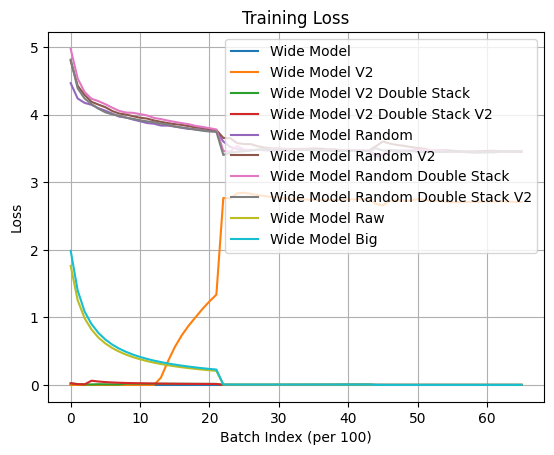

<Figure size 1000x500 with 0 Axes>

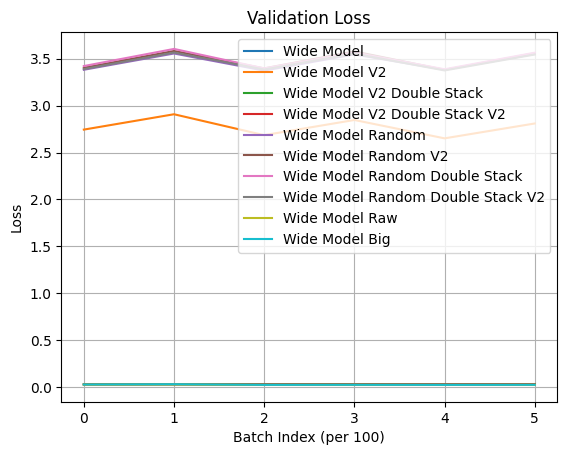

In [423]:
import pandas as pd
import matplotlib.pyplot as plt


# Create DataFrames for training and validation losses
train_data = {
    'Wide Model': WME_train_loss,
    'Wide Model V2': WEZ_train_loss,
    'Wide Model V2 Double Stack': WEZ_train_losses_doubleStack,
    'Wide Model V2 Double Stack V2': WEZ_train_losses_doubleStack_v2,
    'Wide Model Random': WMR_train_losses,
    'Wide Model Random V2': WMR_train_losses_v2,
    'Wide Model Random Double Stack': WEZ_train_losses_doubleStack_R,
    'Wide Model Random Double Stack V2': train_losses_doubleStack_R_v2,
    'Wide Model Raw': RWM_train_losses,
    'Wide Model Big': WBMS_train_losses
}

val_data = {
    'Wide Model': WME_val_loss,
    'Wide Model V2': WEZ_val_loss,
    'Wide Model V2 Double Stack': WEZ_val_losses_doubleStack,
    'Wide Model V2 Double Stack V2': WEZ_val_losses_doubleStack_v2,
    'Wide Model Random': WMR_val_losses,
    'Wide Model Random V2': WMR_val_losses_v2,
    'Wide Model Random Double Stack': WEZ_val_losses_doubleStack_R,
    'Wide Model Random Double Stack V2': val_losses_doubleStack_R_v2,
    'Wide Model Raw': RWM_val_losses,
    'Wide Model Big': WBMS_val_losses
    
}

df_train = pd.DataFrame(train_data)
df_val = pd.DataFrame(val_data)

# Plot the training loss
plt.figure(figsize=(10, 5))
df_train.plot()
plt.title('Training Loss')
plt.xlabel('Batch Index (per 100)')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# Plot the validation loss
plt.figure(figsize=(10, 5))
df_val.plot()
plt.title('Validation Loss')
plt.xlabel('Batch Index (per 100)')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()